# Test GP formulation as batch: Single-Input, Single-Output

In [1]:
import torch
import gpytorch
import importlib

import gpytorch_utils.gp_hyperparam_training
importlib.reload(gpytorch_utils.gp_hyperparam_training)

import gpytorch_utils.gp_utils
importlib.reload(gpytorch_utils.gp_utils)
from gpytorch_utils.gp_hyperparam_training import generate_g_outputs_at_training_inputs
from gpytorch_utils.gp_hyperparam_training import train_GP_models_as_batch_with_nan, set_hyperparameters_to_first_dimension, print_hyperparameters_of_batch
from gpytorch_utils.gp_utils import plot_gp_models_in_batch_single_input
from gpytorch_utils.gp_model import BatchGPModel

## 1. Create offline training data

In [2]:
# batch GP related quantities
n_gp_models_in_batch = 10
n_data_points_in_batch = 100

# evaluation of g as a function of x2 (for offline training)
c = 0.1
def g_eval(x2):
    return -c * x2**2   

# Define offline training points (inputs)
start_x_offline = 0
stop_x_offline = 1.2
n_offline_data = 10
x_train_offline = torch.linspace(start_x_offline, stop_x_offline, n_offline_data)
x_train_offline = x_train_offline.unsqueeze(1)  # tensor of size (n_offline_data,1)
n_GP_inputs = x_train_offline.shape[1]

# Generate observation at training inputs
noise_size = 0.001
y_train_offline = generate_g_outputs_at_training_inputs(g_eval, x_train_offline, noise_size)

# Prepare for batch GP
X_train_batch = torch.zeros((n_gp_models_in_batch, n_data_points_in_batch, 1))
Y_train_batch = torch.full((n_gp_models_in_batch, n_data_points_in_batch), float('nan'))

# Copy the original data into the new tensors
X_train_batch[:, :n_offline_data, :] = x_train_offline.tile(n_gp_models_in_batch, 1, 1) # size of training data (X) for the batch is (n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs)
Y_train_batch[:, :n_offline_data] = y_train_offline.tile(n_gp_models_in_batch, 1)       # size of training data (Y) for the batch is (n_gp_models_in_batch, n_data_points_in_batch)
batch_shape = torch.Size([n_gp_models_in_batch])


## 2. Train hyperparameters

In [3]:
# Initialize likelihood and model
torch.manual_seed(0)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape)  
gp_models_as_batch = BatchGPModel(X_train_batch, Y_train_batch, likelihood, batch_shape)

# Train the batch model 
train_GP_models_as_batch_with_nan(gp_models_as_batch, likelihood, X_train_batch, Y_train_batch, training_iterations = 100)

# Set all hyperparameters to be the same for all GP in the batch
set_hyperparameters_to_first_dimension(gp_models_as_batch, likelihood)

# Print hyperparameters (all GP models sould have the same hyperparameters)
print_hyperparameters_of_batch(gp_models_as_batch,likelihood)

# Set the model to evaluation mode
gp_models_as_batch.eval()
likelihood.eval()

Iter 1/100 - Loss: 0.910
Iter 2/100 - Loss: 0.870
Iter 3/100 - Loss: 0.829
Iter 4/100 - Loss: 0.788
Iter 5/100 - Loss: 0.746
Iter 6/100 - Loss: 0.704
Iter 7/100 - Loss: 0.661
Iter 8/100 - Loss: 0.617
Iter 9/100 - Loss: 0.574
Iter 10/100 - Loss: 0.529
Iter 11/100 - Loss: 0.484
Iter 12/100 - Loss: 0.439
Iter 13/100 - Loss: 0.393
Iter 14/100 - Loss: 0.347
Iter 15/100 - Loss: 0.300
Iter 16/100 - Loss: 0.253
Iter 17/100 - Loss: 0.206
Iter 18/100 - Loss: 0.158
Iter 19/100 - Loss: 0.110
Iter 20/100 - Loss: 0.062
Iter 21/100 - Loss: 0.013
Iter 22/100 - Loss: -0.036
Iter 23/100 - Loss: -0.085
Iter 24/100 - Loss: -0.134
Iter 25/100 - Loss: -0.184
Iter 26/100 - Loss: -0.233
Iter 27/100 - Loss: -0.283
Iter 28/100 - Loss: -0.332
Iter 29/100 - Loss: -0.382
Iter 30/100 - Loss: -0.431
Iter 31/100 - Loss: -0.480
Iter 32/100 - Loss: -0.530
Iter 33/100 - Loss: -0.578
Iter 34/100 - Loss: -0.627
Iter 35/100 - Loss: -0.676
Iter 36/100 - Loss: -0.723
Iter 37/100 - Loss: -0.771
Iter 38/100 - Loss: -0.818
Iter

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 3. Plot resulting GP models

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


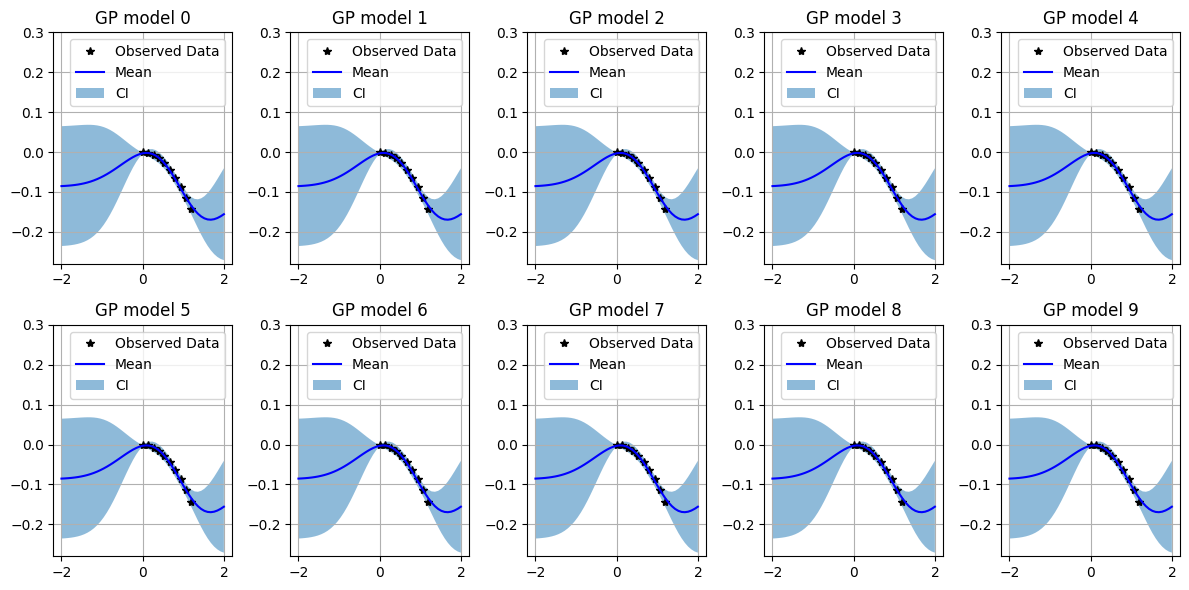

In [4]:
# Plot all GP models in the batch
_, _ = plot_gp_models_in_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, X_train_batch, Y_train_batch, ylim=(-0.28,0.3), figsize=(12,6))

## 4. Update one single GP model in the batch

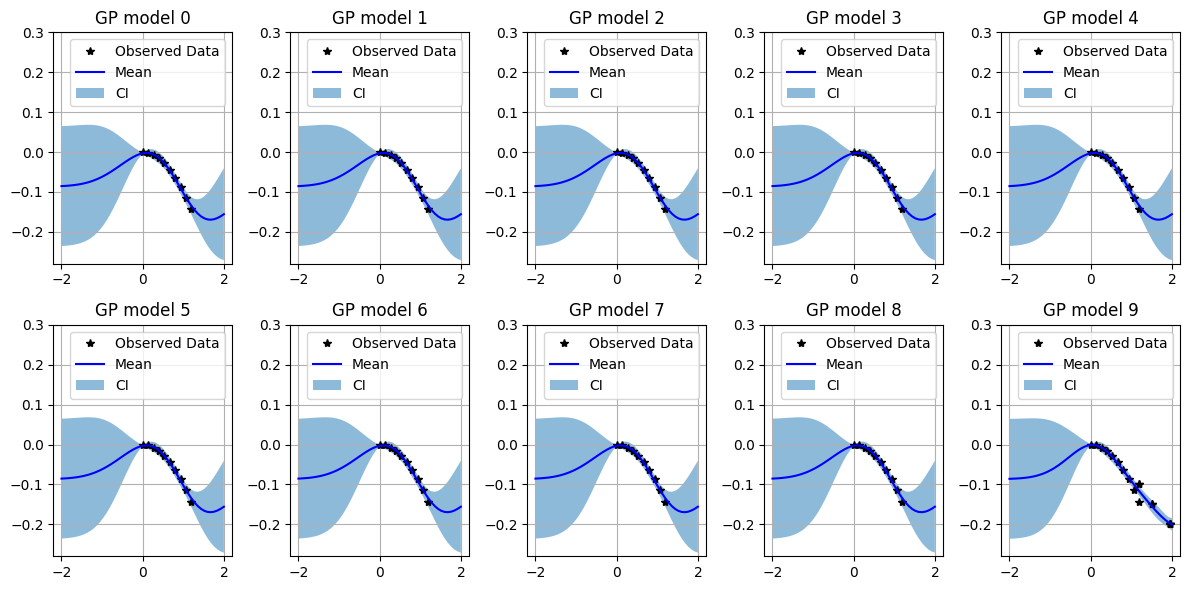

In [5]:
# Update last GP model in the batch
X_train_batch[-1,:n_offline_data+8,:] = torch.cat((torch.tensor([1.96,1.96,1.96,1.96,1.2,1.2,1.5,1.5]),x_train_offline[:,0])).unsqueeze(1)
Y_train_batch[-1,:n_offline_data+8] = torch.cat((torch.tensor([-0.2,-0.2,-0.2,-0.2,-0.1,-0.1,-0.15,-0.15]),y_train_offline.squeeze())).squeeze()
gp_models_as_batch.set_train_data(inputs=X_train_batch, targets=Y_train_batch)

# Plot all GP models in the batch (the last GP model has more training data and therefore a better mean and smaller uncertainty)
_, _ = plot_gp_models_in_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, X_train_batch, Y_train_batch, ylim=(-0.28,0.3), figsize=(12,6))